In [21]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import glob
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage
import spimagine
from scipy.spatial.distance import cdist
%matplotlib qt

In [2]:
# neighborhood_size : kernel size for maxima and minma filter (z,y,x)
# thresholddetermines the threshold differnece between maximum peak intensity and background to count as a bead
def detectBeads(img,neighborhood_size = (50,15,15),threshold = 1500):
    
    data = img
    
    # Bead segmentation, the mask of the bead is in maxima
    print("Mask formation")
    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)                                    
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = ((data_max - data_min) > threshold)
    maxima[diff == 0] = 0

    # Isolating beads from the mask
    print("Mask labeling")
    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)
    x, y, z = [], [], []
    for dz,dy,dx in slices:
        z_center = (dz.start + dz.stop - 1)/2
        z.append(z_center)
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
    
    return (z,y,x)

In [3]:
def visualizeBeadDetectionByMaxProjection(img,z,y,x):
    plt.imshow(np.max(img,axis = 0))
    plt.axis('OFF')
    for i,_ in enumerate(x):
        plt.plot(x[i],y[i],'r.',alpha = 0.15)

In [4]:
def loadImage(fileName, rawImage = True, dimZ = 100, dimY = 512, dimX = 512):
    if rawImage:
        return (np.fromfile(fileName,dtype=np.dtype('<u2')).reshape((dimZ,dimY,dimX)))
    else:
        return tifffile.imread(fileName)

Smoothening by gaussian filtering
Mask formation
Mask labeling


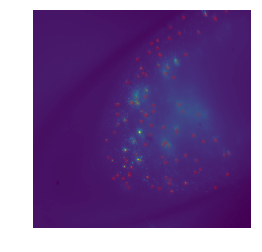

In [6]:
# Scaled down droso image
img = loadImage("Z://Deb//uNS//2018-09-04-18-59-55-07-uNS_LightSheetLED//stacks//C0L0/000000-2.tif",False)
print("Smoothening by gaussian filtering")
gImg = filters.gaussian_filter(img,2)

(z,y,x) = detectBeads(gImg,threshold=1500)
visualizeBeadDetectionByMaxProjection(img,z,y,x)

In [60]:
# Beads in Agarose
img = loadImage("D://Data//2018-09-07-12-59-48-33-RandomZernikeAstigmationBeads//stacks//C0L0/000000.raw",True,401,1024,1024)
print("Smoothening by gaussian filtering")
gImg = filters.gaussian_filter(img,2)
(z,y,x) = detectBeads(gImg,threshold=20,neighborhood_size=(50,10,10))
visualizeBeadDetectionByMaxProjection(img,z,y,x)

Smoothening by gaussian filtering
Mask formation
Mask labeling
